In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


In [3]:
f = fits.open('data/VIRGO_1min_0083-7404.fits')

In [4]:
f[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

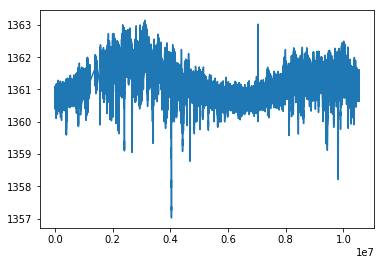

In [5]:
fluxes = f[0].data #[f[0].data != -99]
times = np.arange(len(fluxes))

interp_fluxes = np.interp(times[fluxes == -99], times[fluxes != -99], fluxes[fluxes != -99])
fluxes[fluxes == -99] = interp_fluxes

plt.plot(times, fluxes)

In [6]:
from scipy.signal import periodogram
f, Pxx_den = periodogram(fluxes, fs=1/60)#, scaling='spectrum')

In [7]:
from scipy.stats import binned_statistic

bs = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanmedian, bins=500)

# bs_std = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanstd, bins=500)

bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(0.1, 1000000.0)

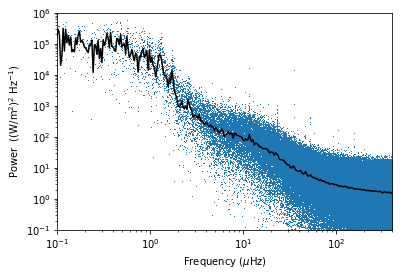

In [8]:
fig, ax = plt.subplots()
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True)
ax.loglog(1e6 * np.exp(bincenters), bs.statistic, color='k')
plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')
plt.xlim([0.1, 400])
plt.ylim([1e-1, 1e6])

# plt.ylim([1e-9, 1e-3])

# plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)
# plt.axvline(10.9*365, ls='--')
#plt.xlim([0, 0.3])

In [9]:
y = bs.statistic[1e6 * np.exp(bincenters) < 400]
x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < 400]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

#x = np.log10(x[~np.isnan(y)][3:])
#y = np.log10(y[~np.isnan(y)][3:])

# def lnmodel(p, nu=x):
#     a1, b1, c1, a2, b2, c2, a3, b3, c3 = p
#     s = np.zeros_like(nu)
#     for a, b, c in zip([a1, b1, c1], [a2, b2, c2], [a3, b3, c3]):
#         s += a / (1 + (b * nu)**c)
#     return np.log(s)

# def lnmodel(p, ln_nu=x):
#     a1, b1, c1, a2, b2, c2, c3 = p
#     s = np.zeros_like(ln_nu)
#     for a, b, c in [[a1, b1, c1], [a2, b2, c2]]:
#         s += a / (1 + (b * np.exp(ln_nu))**c)
#     return np.log(s) + c3

# def minimize(p, yerr=1e-4): 
#     return np.sum((lnmodel(p) - y)**2 / yerr**2)

# from scipy.optimize import fmin_l_bfgs_b

# initp = [500, 1, 2, 10, 0.3, 3, 0]
# bounds = [[300, 400], [0, 3], [1, 2], [10, 12], [0, 1], [0, 3], [-1, 1]]
# bestp = fmin_l_bfgs_b(minimize, initp, approx_grad=True, bounds=bounds)[0]

# plt.plot(x, y)
# plt.plot(x, lnmodel(initp))
# plt.plot(x, lnmodel(bestp))

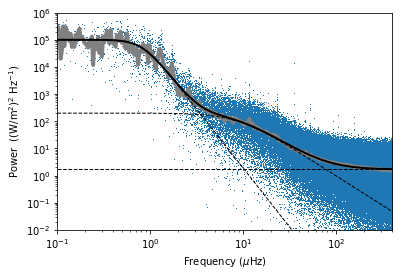

In [10]:
def individual_model(p, nu=x):
    a, b, c = p
    s = a / (1 + (b * nu)**c)
    return s

def model(p, nu=x):
    s = np.zeros_like(nu)
    for a, b, c in np.array(p).reshape((len(p)//3, 3)):
        s += a / (1 + (b * nu)**c)
    return s
    
# def minimize(p):
#     return np.sum( (y - model(p))**2 / np.sqrt(y)**2)

def minimize(p):
    return np.sum( (np.log10(y) - np.log10(model(p)))**2 )

from scipy.optimize import fmin_l_bfgs_b

initp = [1e5, 1.5, 4, 
         200, 0.08, 3, 
         2, 0, 3]
bounds = [[0.5e5, 3e5], [0.3, 2], [2, 5], 
          [100, 300], [0, 1], [2, 5], 
          [0, 5], [-1, 1], [2, 5]]
bestp = fmin_l_bfgs_b(minimize, initp, bounds=bounds, approx_grad=True)[0]
plt.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
plt.loglog(x, y, color='gray', lw=4, label='Binned')
# plt.loglog(1e6 * x, model(initp))
plt.loglog(x, model(bestp), color='k', lw=2, label='Fit')

plt.loglog(x, individual_model(bestp[:3]), color='k', lw=1, ls='--')

plt.loglog(x, individual_model(bestp[3:6]), color='k', lw=1, ls='--')

plt.loglog(x, individual_model(bestp[6:9]), color='k', lw=1, ls='--')

plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

plt.xlim([1e-1, 400])
plt.ylim([1e-2, 1e6])
plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

In [11]:
bestp

array([1.00000000e+05, 1.23103701e+00, 4.33975830e+00, 1.99993394e+02,
       1.14986842e-01, 2.17919250e+00, 1.68761501e+00, 0.00000000e+00,
       3.00000000e+00])

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

import celerite
from celerite import terms

# N = 1500
# K = 1
# # Set up a simple celerite model
# kernel = terms.RealTerm(20, 3) #+ terms.ComplexTerm(0.5, 0.05, 3.0)
# gp = celerite.GP(kernel)

# # Simulate K datasets with N points
# t = np.linspace(0, 24, 24*60*60)
# gp.compute(t)
# np.random.seed(42)
# y = gp.sample(size=K)

# # Compute the FFT based power spectrum estimates
# freqs_true = np.fft.rfftfreq(len(t), t[1] - t[0])

# # Compute the true power spectrum
# # NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
# power_true = kernel.get_psd(2*np.pi*freqs_true)

# # >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
# power_true /= 2*np.pi

# # Let's plot the estimates of the PSD
# plt.figure()
# plt.loglog(freqs_true, power_true, label="truth")
# plt.xlim([freqs_true.min(), freqs_true.max()])
# plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
# plt.xlabel("frequency [Hz]")
# plt.title("$N = {0}$".format(N))
# plt.legend();

In [16]:
def model(p):
    log_S0, log_Q, log_omega0 = p
    kernel = terms.SHOTerm(log_S0, log_Q, log_omega0) #+ terms.ComplexTerm(0.5, 0.05, 3.0)
    gp = celerite.GP(kernel)

    # Simulate K datasets with N points
    t = np.linspace(0, 24, 24*60*60)
#     gp.compute(t)
#     np.random.seed(42)
#     y = gp.sample(size=K)

    # Compute the FFT based power spectrum estimates
    freqs_true = np.fft.rfftfreq(len(t), t[1] - t[0])

    # Compute the true power spectrum
    # NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
    power_true = kernel.get_psd(2*np.pi*freqs_true)

    # >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
    power_true /= 2*np.pi
    
    return freqs_true, power_true

def minimize1(p):
    freqs_true, power_true = model(p)
    interp_power = np.interp(x, freqs_true, power_true)
    return np.sum( (np.log(interp_power) - np.log(individual_model(bestp[:3])))**2 )

def minimize2(p):
    freqs_true, power_true = model(p)
    interp_power = np.interp(x, freqs_true, power_true)
    return np.sum( (np.log(interp_power) - np.log(individual_model(bestp[3:6])))**2 )

def minimize3(p):
    freqs_true, power_true = model(p)
    interp_power = np.interp(x, freqs_true, power_true)
    return np.sum( (np.log(interp_power) - np.log(individual_model(bestp[6:9])))**2 )


from scipy.optimize import fmin_powell
bestp1 = fmin_powell(minimize1, [7.5, -5.5, 9.2])
bestp2 = fmin_powell(minimize2, [7.5, -5.5, 9.2])
bestp3 = fmin_powell(minimize3, [7.5, -5.5, 9.2])

bestp1, bestp2, bestp3

Optimization terminated successfully.
         Current function value: 4869.877558
         Iterations: 5
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: 4.191951
         Iterations: 4
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 393


(array([ 14.39791354, -10.53654585,   8.7891114 ]),
 array([ 7.39288042, -5.41659644,  9.21946572]),
 array([ 2.58698472, -0.34656487, 12.7745909 ]))

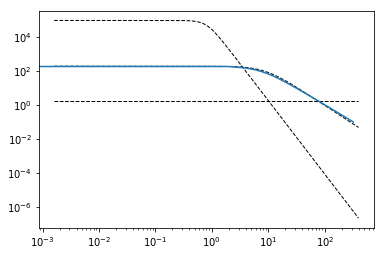

In [17]:
plt.loglog(x, individual_model(bestp[:3]), color='k', lw=1, ls='--')

plt.loglog(x, individual_model(bestp[3:6]), color='k', lw=1, ls='--')

plt.loglog(x, individual_model(bestp[6:9]), color='k', lw=1, ls='--')

#kernel = terms.SHOTerm(45, 0, -5) + terms.SHOTerm(7, 0, 5)#terms.RealTerm() + terms.RealTerm()
kernel = terms.SHOTerm(*bestp2)#terms.RealTerm() + terms.RealTerm()
# gp = celerite.GP(kernel)

# #t = np.linspace(0, 24, 24*60*60)
# gp.compute(x)
# np.random.seed(42)
# y = gp.sample()

# Compute the FFT based power spectrum estimates
freqs_true = np.fft.rfftfreq(len(x), x[1] - x[0])
# omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))

# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*freqs_true)

# for k in gp.kernel.terms:
#     plt.plot(freqs_true, k.get_psd(2*np.pi*freqs_true), "--")

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

plt.loglog(freqs_true, power_true)

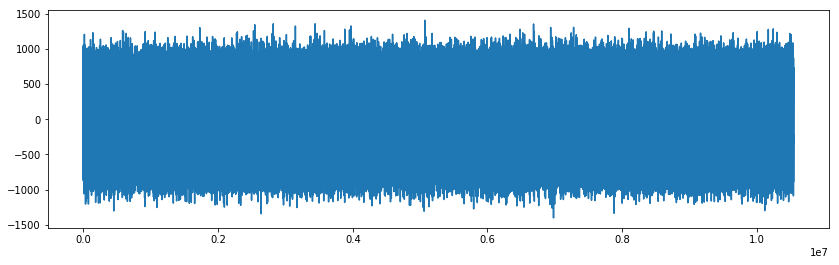

In [18]:
kernel = terms.SHOTerm(*bestp2)
gp = celerite.GP(kernel)

#t = np.linspace(0, 24, 24*60*60)
gp.compute(times)
np.random.seed(42)
y = gp.sample()

plt.figure(figsize=(14, 4))
plt.plot(times, y)

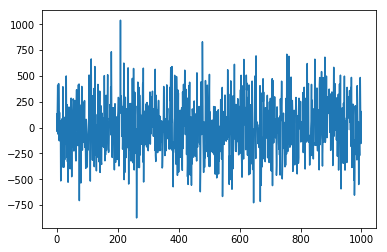

In [31]:
plt.plot(times[:1000], y[:1000])

In [22]:
f_test, Pxx_den_test = periodogram(y, fs=1/60)#, scaling='spectrum')

(0.0001, 100000000.0)

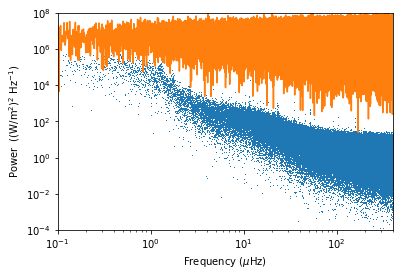

In [28]:
fig, ax = plt.subplots()
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True)

ax.loglog(1e6 * f_test, Pxx_den_test)

plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')
plt.xlim([1e-1, 400])
plt.ylim([1e-4, 1e8])

In [443]:
# import celerite
# from celerite import terms 

# x = times[::10]
# y = fluxes[::10]

# # A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# gp = celerite.GP(kernel)
# gp.compute(x)

# #plt.loglog(1e6 * np.exp(bincenters), bs.statistic, color='k')

# from scipy.optimize import minimize

# def neg_log_like(params, y, gp):
#     gp.set_parameter_vector(params)
#     return -gp.log_likelihood(y)

# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

# r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
# gp.set_parameter_vector(r.x)
# print(r)

# power_true = kernel.get_psd(2*np.pi*f)

# # >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
# freqs = np.fft.rfftfreq(len(times), times[1] - times[0])
# power_true /= 2*np.pi
# plt.loglog(freqs, power_true, label="truth")